In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


# Transfer Learning

In this notebook we show how transfer learning can be used to fine tune an existing CNN model solving a multi-class classification task in solving another classification problem in the context of a slightly diffrerent dataset.


First we build a CNN from scratch to classify fashion items categories from Fashion-MNIST dataset.

Later, we have used this pre-trained model and finetuned it to classify 10 handwritten digits from MNIST-Digits dataset.


### Read Fashion-MNIST Dataset

In [1]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


# PART 1:  Lets Build a CNN - Later it will be used for Transfer Learning

# This CNN will Classify 10 types of fashion items in the Fashion-MNIST Dataset 

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:

Label 	Description

0 	T-shirt/top

1 	Trouser

2 	Pullover

3 	Dress

4 	Coat

5 	Sandal

6 	Shirt

7 	Sneaker

8 	Bag

9 	Ankle boot

## Check an Image from the Dataset

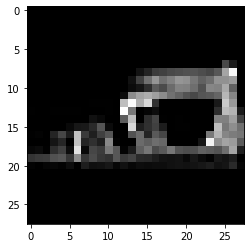

Digit : 0


In [4]:
import matplotlib.pyplot as plt
import numpy as np

ind = 7434
sample_image = X_train[ind] 
pixels = sample_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('Digit :',np.argmax(y_train[ind]))

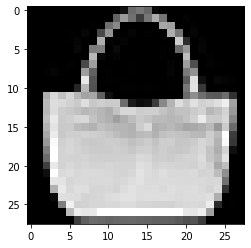

Digit : 0


In [5]:
ind = 100
sample_image = X_train[ind] 
pixels = sample_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('Digit :',np.argmax(y_train[ind]))

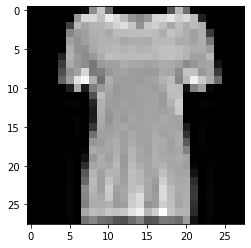

Digit : 0


In [6]:
ind = 10
sample_image = X_train[ind] 
pixels = sample_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('Digit :',np.argmax(y_train[ind]))

In [ ]:

images_train = X_train
labels_train = y_train

images_test = X_test
labels_test = y_test

labels_train=np.array(labels_train).reshape(-1,1)
labels_test=np.array(labels_test).reshape(-1,1)

# Ohe-hot encoding of the target labels
onehot=OneHotEncoder()
onehot.fit(labels_train)

labels_train=onehot.transform(labels_train)
labels_test=onehot.transform(labels_test)
labels_train=labels_train.toarray()
labels_test=labels_test.toarray()

# Normalize Data
images_train=np.array(images_train).reshape(60000,784)/255
images_test=np.array(images_test).reshape(10000,784)/255

# Convert to float
images_train=images_train.reshape(60000, 28, 28,1).astype('float32')
images_test=images_test.reshape(10000, 28, 28, 1).astype('float32')

## Build a CNN Model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.models import model_from_json

from keras import Model

In [ ]:
model = Sequential()

# Feature extractor
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))

model.add(Flatten())

# Image classifier
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)             

### Train the CNN

In [ ]:
model.fit(images_train, labels_train, validation_data=(images_test, labels_test), epochs=5, batch_size=50, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 223s 4ms/step - loss: 0.4046 - accuracy: 0.8519 - val_loss: 0.2995 - val_accuracy: 0.8876
Epoch 2/5
60000/60000 [==============================] - 226s 4ms/step - loss: 0.2534 - accuracy: 0.9081 - val_loss: 0.2706 - val_accuracy: 0.9048
Epoch 3/5
60000/60000 [==============================] - 224s 4ms/step - loss: 0.2126 - accuracy: 0.9221 - val_loss: 0.2473 - val_accuracy: 0.9135
Epoch 4/5
60000/60000 [==============================] - 223s 4ms/step - loss: 0.1795 - accuracy: 0.9333 - val_loss: 0.2367 - val_accuracy: 0.9183
Epoch 5/5
60000/60000 [==============================] - 222s 4ms/step - loss: 0.1518 - accuracy: 0.9426 - val_loss: 0.2453 - val_accuracy: 0.9183


### Save the CNN for Later Use/Distribution - Model Serialization 

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()

# Save the Model Architecture of the CNN
with open("Fashion_MNIST_CNN_Architecture.json", "w") as json_file:
    json_file.write(model_json)
    
# Save the trained weights
model.save_weights("Fashion_MNIST_CNN_Weights.h5")

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Part 2: Use the Previous CNN for Transfer Learning

Lets see how we can use the previous CNN model (10 class Fashion-MNIST classification) and fine-tune this model to solve another classification task (10-class MNIST Digits classification).

### Load Data MNIST-Digits Dataset


In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_classes = 10
#images_train = X_train
#labels_train = y_train

#images_test = X_test
#labels_test = y_test

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert the class labels into one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


60000 train samples
10000 test samples


In [ ]:
#X_train.shape, X_test.shape

### Load the Pre-trained CNN from the Disk File

In [ ]:
json_file = open('Fashion_MNIST_CNN_Architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)             

### Initialize the CNN with the Pre-trained Weights

In [ ]:
loaded_model.load_weights("Fashion_MNIST_CNN_Weights.h5")

## Freeze all the Layers of the Loaded CNN

We don't want to re-train these layers with our new data.

In [ ]:
for l in loaded_model.layers:
    l.trainable = False

In [ ]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)             

### Discard the Last few layers (including the output layer) of the Loaded CNN.

### We want the output from the CNN till the convolutional layer.

### Now repurpose the network by adding new layers as we need.

In [ ]:
# Functional API of Keras

intermediate = loaded_model.get_layer('conv2d_2').output

conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(intermediate)
conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv_2)
flat = Flatten()(maxpool1)
dense_1 = Dense(512, activation='relu')(flat)

### Add A New Output Layer at the End of the Second Dense Layer of the Loaded CNN Model

In [ ]:
# Now the output will be a 10-neuron Softmax Layer
last_layer = Dense(10, activation='softmax', name='last_layer')(dense_1)

### Finally, set the Input and Output Layer of the Model

In [ ]:
new_model = Model(inputs = loaded_model.input, outputs = last_layer)

### Compile the Model

In [ ]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0   

### Train on the New Data

In [ ]:
images_train.shape
#images_train[0].shape


(60000, 28, 28, 1)

In [ ]:
new_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=50, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0996 - accuracy: 0.9685 - val_loss: 0.0417 - val_accuracy: 0.9855
Epoch 2/5
60000/60000 [==============================] - 268s 4ms/step - loss: 0.0327 - accuracy: 0.9900 - val_loss: 0.0249 - val_accuracy: 0.9907
Epoch 3/5
60000/60000 [==============================] - 272s 5ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0251 - val_accuracy: 0.9917
Epoch 4/5
60000/60000 [==============================] - 265s 4ms/step - loss: 0.0157 - accuracy: 0.9948 - val_loss: 0.0288 - val_accuracy: 0.9919
Epoch 5/5
60000/60000 [==============================] - 271s 5ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0326 - val_accuracy: 0.9901


### Evaluate the Model

In [ ]:
p = new_model.predict(X_test)

In [ ]:
labels_test_predicted = np.argmax(p,1)

In [ ]:
pd.crosstab(np.argmax(y_test,axis=1),labels_test_predicted)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,30,4,182,31,122,8,53,230,322,18
1,0,34,5,0,196,0,14,721,5,25
2,197,2,165,23,228,5,21,42,8,309
3,23,177,74,7,313,8,125,80,173,20
4,289,14,166,3,252,0,24,31,15,206
5,26,2,628,66,48,127,6,75,16,6
6,118,4,188,9,239,5,37,146,105,149
7,24,0,837,0,126,1,1,6,1,4
8,89,5,622,32,169,3,41,18,7,14
